In [1]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:

#2.1 Get the file
downloaded = drive.CreateFile({'id':'1b6HpkkpNjIyIOIfCzQIJ9kfZ76L-rA4i'}) # replace the id with id of file you want to access
downloaded.GetContentFile('zomato.csv') 


# Predicting Zomato Restaurants Rate

#### Columns description

- **url** : contains the url of the restaurant in the zomato website

- **address** : contains the address of the restaurant in Bengaluru

- **name** : contains the name of the restaurant

- **online_order** : whether online ordering is available in the restaurant                      or not

- **book_table** : table book option available or not

- **rate** : contains the overall rating of the restaurant out of 5

- **votes** : contains total number of rating for the restaurant as of the                 above mentioned date

- **phone** : contains the phone number of the restaurant

- **location** : contains the neighborhood in which the restaurant is                        located

- **rest_type** : restaurant type

- **dish_liked** : dishes people liked in the restaurant

- **cuisines** : food styles, separated by comma

- **approx_cost(for two people)** : contains the approximate cost for meal                                       for two people

- **reviews_list** : list of tuples containing reviews for the restaurant,                        each tuple

- **menu_item** : contains list of menus available in the restaurant

- **listed_in(type)** : type of meal

- **listed_in(city)** : contains the neighborhood in which the restaurant is                         listed

## Importing Necessary Libraries

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import OneHotEncoder

from joblib import dump,load
#%matplotlib notebook
%matplotlib inline


from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import  make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import random
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor

import pickle


import warnings
warnings.filterwarnings('ignore')

## Understanding Data

In [5]:
# df = pd.read_csv('C:/Users/prash/Downloads/archive(3)/zomato.csv')
df = pd.read_csv('zomato.csv')

df.shape

(51717, 17)

In [6]:
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [7]:
df.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

In [9]:
df.dtypes

url                            object
address                        object
name                           object
online_order                   object
book_table                     object
rate                           object
votes                           int64
phone                          object
location                       object
rest_type                      object
dish_liked                     object
cuisines                       object
approx_cost(for two people)    object
reviews_list                   object
menu_item                      object
listed_in(type)                object
listed_in(city)                object
dtype: object

In [10]:
df.describe()

,votes
count,51717.000000
mean,283.697527
std,803.838853
min,0.000000
25%,7.000000
50%,41.000000
75%,198.000000
max,16832.000000


#### Observations
- Minimum vote's value is 0, can be interpret as there are some restaurants who have 0 votes
- Maximum vote's value is 16832, there is a restaurant who has max   16832.
- Average vote's values is 284, so average 284 votes for restaurant

## Data Preprocessing

##### Dropping Unnecessary Columns.
##### And Adjusting column names for convininent

* Dropping address and listed_in(city) because they are representing same information.

* url, Phone columns not required so dropping these also.

In [11]:
dropping_columns = ["address", "url", "listed_in(city)", "phone"]

df.drop(columns=dropping_columns, axis=1, inplace=True)

In [12]:
df.columns

Index(['name', 'online_order', 'book_table', 'rate', 'votes', 'location',
       'rest_type', 'dish_liked', 'cuisines', 'approx_cost(for two people)',
       'reviews_list', 'menu_item', 'listed_in(type)'],
      dtype='object')

##### Checking and Removing Duplicates

In [13]:
df.duplicated().sum()

9809

In [14]:
print("No of Duplicates in dataset: ",df.duplicated().sum())

No of Duplicates in dataset:  9809


In [15]:
df.drop_duplicates(inplace=True)

In [16]:
# Removing Null alues

df.isnull().sum()

name                               0
online_order                       0
book_table                         0
rate                            4252
votes                              0
location                          14
rest_type                        172
dish_liked                     20206
cuisines                          36
approx_cost(for two people)      253
reviews_list                       0
menu_item                          0
listed_in(type)                    0
dtype: int64

In [17]:
for col in df.columns:
    print("{} has  {} % missing values".format(col,round(df[col].isnull().sum()/len(df)*100,4)))
        

name has  0.0 % missing values
online_order has  0.0 % missing values
book_table has  0.0 % missing values
rate has  10.146 % missing values
votes has  0.0 % missing values
location has  0.0334 % missing values
rest_type has  0.4104 % missing values
dish_liked has  48.2151 % missing values
cuisines has  0.0859 % missing values
approx_cost(for two people) has  0.6037 % missing values
reviews_list has  0.0 % missing values
menu_item has  0.0 % missing values
listed_in(type) has  0.0 % missing values


In [18]:
(df.isnull().sum()/len(df)*100).round(2)

name                            0.00
online_order                    0.00
book_table                      0.00
rate                           10.15
votes                           0.00
location                        0.03
rest_type                       0.41
dish_liked                     48.22
cuisines                        0.09
approx_cost(for two people)     0.60
reviews_list                    0.00
menu_item                       0.00
listed_in(type)                 0.00
dtype: float64

In [19]:
df['rate'].unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', nan, '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

In [20]:
df['rate'] = df['rate'].replace('NEW', np.NaN)
df['rate'] = df['rate'].replace('-', np.NaN)

In [21]:
df['rate'].unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', nan, '2.9/5', '3.5/5', '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

In [22]:
(df.isnull().sum()/len(df)*100).round(2)

name                            0.00
online_order                    0.00
book_table                      0.00
rate                           14.11
votes                           0.00
location                        0.03
rest_type                       0.41
dish_liked                     48.22
cuisines                        0.09
approx_cost(for two people)     0.60
reviews_list                    0.00
menu_item                       0.00
listed_in(type)                 0.00
dtype: float64

##### converting `rate` into `string` type and converting '4.1/5' to '4.1'  then again changing data type to `float`


In [23]:
df['rate'] = df['rate'].astype(str)

df['rate'] = df['rate'].apply(lambda x: x.replace('/5', ''))

df['rate'] = df['rate'].apply(lambda x: float(x))

In [24]:
df['rate'].head()

0    4.1
1    4.1
2    3.8
3    3.7
4    3.8
Name: rate, dtype: float64

In [25]:
type(df['reviews_list'][0])

str

In [26]:
df['reviews_list'] = df['reviews_list'].apply(lambda x: ast.literal_eval(x))
type(df['reviews_list'][0])

list

In [27]:
df['reviews_list'][0][0]

('Rated 4.0',
 'RATED\n  A beautiful place to dine in.The interiors take you back to the Mughal era. The lightings are just perfect.We went there on the occasion of Christmas and so they had only limited items available. But the taste and service was not compromised at all.The only complaint is that the breads could have been better.Would surely like to come here again.')

In [28]:
df['reviews_list'][0][1]

('Rated 4.0',
 'RATED\n  I was here for dinner with my family on a weekday. The restaurant was completely empty. Ambience is good with some good old hindi music. Seating arrangement are good too. We ordered masala papad, panner and baby corn starters, lemon and corrionder soup, butter roti, olive and chilli paratha. Food was fresh and good, service is good too. Good for family hangout.\nCheers')

In [29]:
extracted = [float(i[0].replace('Rated','').strip()) for i in df['reviews_list'][0]]
extracted

[4.0, 4.0, 2.0, 4.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 4.0, 4.0]

In [30]:
extracted_mean = round((sum(extracted)/len(extracted)),1)
extracted_mean

4.1

In [31]:
print("Extracted Rate: ",extracted_mean)
print("Original Rate: ",df['rate'][0])

Extracted Rate:  4.1
Original Rate:  4.1


In [32]:
def extract_features_from_review_list(x):
    '''
    extract the rate value out of a string inside tuple
    '''
    # ensure that x is not Null and there is more than one rate
    if not x or len(x) <= 1:
        return None
    
    ## checked give values is text or not, if it is text then removed 'Rated', convert string to float.
    rate = [float(i[0].replace('Rated','').strip())  for i in x if type(i[0])== str]
    
    ## return average value
    return round((sum(rate)/len(rate)),1)

In [33]:
# create new column
df['review_rate']  = df['reviews_list'].apply(lambda x : extract_features_from_review_list(x))

In [34]:
## Compare "Original Rate" vs "Rate extracted from Review List"
df.loc[:,['rate','review_rate']].sample(10,random_state=1)

,rate,review_rate
43076,4.0,4.0
49259,3.3,NaN
43257,4.5,4.2
30157,3.3,3.1
41110,3.8,4.0
34220,4.0,4.0
42520,3.0,3.3
45657,3.2,2.3
38218,3.3,3.9
4568,NaN,3.5


In [35]:
df.rate.isna().sum()

5914

In [36]:
## finding rate = NaN and review_rate == not NaN
df.query('rate != rate & review_rate == review_rate')[:5]

,name,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),review_rate
72,Spicy Tandoor,No,No,NaN,0,Banashankari,Quick Bites,NaN,North Indian,150,"[(Rated 4.0, RATED\n cost for chicken rolls i...",[],Delivery,4.5
90,Me And My Cake,No,No,NaN,0,Banashankari,Delivery,NaN,"Bakery, Desserts",500,"[(Rated 1.0, RATED\n Do not order anything. T...",[],Delivery,1.0
110,Hari Super Sandwich,No,No,NaN,0,Banashankari,"Takeaway, Delivery",NaN,"Sandwich, Pizza, Beverages",200,"[(Rated 1.0, RATED\n I have been here many ti...",[],Delivery,1.0
116,Wood Stove,No,No,NaN,0,Banashankari,"Takeaway, Delivery",NaN,South Indian,150,"[(Rated 5.0, RATED\n Wow this food is great ?...",[],Delivery,5.0
138,Sri Murari Family Restaurant,No,No,NaN,0,Banashankari,Quick Bites,NaN,Biryani,250,"[(Rated 4.0, RATED\n This tiny mess near kath...",[],Delivery,4.5


In [37]:
## finding index where rate==NaN and review_rate== not NaN
nan_index = df.query('rate != rate & review_rate == review_rate').index
for i in nan_index:
    df.loc[i,'rate'] = df.loc[i,'review_rate'] 

In [38]:
df.rate.isna().sum()

4861

In [39]:
((df.isna().sum()/len(df))*100).round(2)

name                            0.00
online_order                    0.00
book_table                      0.00
rate                           11.60
votes                           0.00
location                        0.03
rest_type                       0.41
dish_liked                     48.22
cuisines                        0.09
approx_cost(for two people)     0.60
reviews_list                    0.00
menu_item                       0.00
listed_in(type)                 0.00
review_rate                    25.71
dtype: float64

In [40]:
df.drop(columns='review_rate',axis=1,inplace=True)

In [41]:
df.rate.isna().sum()

4861

In [42]:
# drop null values
df.dropna(subset=['rate', 'approx_cost(for two people)'],inplace=True)

In [43]:
df.shape

(36840, 13)

In [44]:
df.isnull().sum()

name                               0
online_order                       0
book_table                         0
rate                               0
votes                              0
location                           0
rest_type                        121
dish_liked                     15277
cuisines                           8
approx_cost(for two people)        0
reviews_list                       0
menu_item                          0
listed_in(type)                    0
dtype: int64

In [45]:
df = df[df['cuisines'].isnull()==False]

In [46]:
df.rename(columns={'approx_cost(for two people)': 'average_cost'}, inplace=True)

In [47]:
((df.isnull().sum()/len(df))*100).round(2)

name                0.00
online_order        0.00
book_table          0.00
rate                0.00
votes               0.00
location            0.00
rest_type           0.33
dish_liked         41.46
cuisines            0.00
average_cost        0.00
reviews_list        0.00
menu_item           0.00
listed_in(type)     0.00
dtype: float64

In [48]:
df['dish_liked'] = df['dish_liked'].apply(lambda x:x.lower().strip() if isinstance(x,str) else x)

In [49]:
df['dish_liked'][:2]

0    pasta, lunch buffet, masala papad, paneer laja...
1    momos, lunch buffet, chocolate nirvana, thai g...
Name: dish_liked, dtype: object

In [50]:
menu_list = []

# collect the dishes' names and make a menu list for all kind of dishes
for dish in df.dish_liked.tolist():
    if isinstance(dish,str) and len(dish)>0:
        for e in dish.split(','):
            menu_list.append(e)
len(menu_list)

118363

In [51]:
# Now collect the unique dish name 
menu_set = set(menu_list)

In [52]:
def clear_text(t):
    return ' '.join([i[1] for i in t]).encode('utf8').decode('ascii',errors='replace')
    

In [53]:
df['process_text'] = df['reviews_list'].apply(lambda x: clear_text(x))

In [54]:
df['process_text'] 

0        RATED\n  A beautiful place to dine in.The inte...
1        RATED\n  Had been here for dinner with family....
2        RATED\n  Ambience is not that good enough and ...
3        RATED\n  Great food and proper Karnataka style...
4        RATED\n  Very good restaurant in neighbourhood...
                               ...                        
51709    RATED\n  Ambience- Big and spacious lawn was u...
51711    RATED\n  A fine place to chill after office ho...
51712    RATED\n  Food and service are incomparably exc...
51715    RATED\n  Nice and friendly place and staff is ...
51716    RATED\n  Great ambience , looking nice good se...
Name: process_text, Length: 36832, dtype: object

In [55]:
# here we removed all above mentioned characters

df['process_text'] = df['process_text'].apply(lambda x : x.replace("RATED\n  ",'').replace('?','').replace('�','').replace('\n','').replace('.',' ').strip().lower())

In [56]:
df['process_text'][0]

'a beautiful place to dine in the interiors take you back to the mughal era  the lightings are just perfect we went there on the occasion of christmas and so they had only limited items available  but the taste and service was not compromised at all the only complaint is that the breads could have been better would surely like to come here again  i was here for dinner with my family on a weekday  the restaurant was completely empty  ambience is good with some good old hindi music  seating arrangement are good too  we ordered masala papad, panner and baby corn starters, lemon and corrionder soup, butter roti, olive and chilli paratha  food was fresh and good, service is good too  good for family hangout cheers its a restaurant near to banashankari bda  me along with few of my office friends visited to have buffet but unfortunately they only provide veg buffet  on inquiring they said this place is mostly visited by vegetarians  anyways we ordered ala carte items which took ages to come  

In [57]:
df['dish_liked'].nunique()

5250

In [58]:
# make lower case
df['dish_liked'] = df['dish_liked'].apply(lambda x:x.lower().strip() if isinstance(x,str) else x)

In [59]:
df['dish_liked'][10000]

nan

In [60]:
menu_set.intersection(df['process_text'][10000].split(' '))

{'chicken', 'fish', 'rice', 'thali'}

In [61]:
df['dish_n_review'] = df['process_text'].apply(lambda x: ', '.join(list(menu_set.intersection(x.split(' ')))))

In [62]:
df.query('dish_liked != dish_liked')[['dish_liked','dish_n_review']].sample(5,random_state=1)

,dish_liked,dish_n_review
32901,NaN,"kheer, halwa"
44323,NaN,"prawn, chicken, shawarma, tikka, rice"
6479,NaN,
11046,NaN,rice
50112,NaN,"cappuccino, coffee"


In [63]:
nan_index = df.query('dish_liked != dish_liked & dish_n_review == dish_n_review').index
for i in nan_index:
    df.loc[i,'dish_liked'] = df.loc[i,'dish_n_review']

In [64]:
df['dish_liked'][10000]

'rice, thali, chicken, fish'

In [65]:
del menu_list
del menu_set

In [66]:
df.drop(columns=['dish_n_review'],axis=1,inplace=True)

In [67]:
((df.isnull().sum()/len(df))*100).round(4)

name               0.0000
online_order       0.0000
book_table         0.0000
rate               0.0000
votes              0.0000
location           0.0000
rest_type          0.3285
dish_liked         0.0000
cuisines           0.0000
average_cost       0.0000
reviews_list       0.0000
menu_item          0.0000
listed_in(type)    0.0000
process_text       0.0000
dtype: float64

In [68]:
df.shape

(36832, 14)

### Visualizations

Mean is : 3.7208921589921835


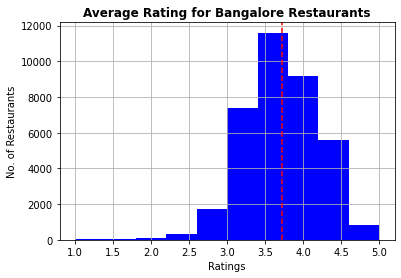

In [69]:
df['rate'].hist(color = 'blue')
plt.axvline(x=df['rate'].mean(), ls = '--', color = 'red')
plt.title("Average Rating for Bangalore Restaurants",weight = 'bold')
plt.xlabel("Ratings")
plt.ylabel("No. of Restaurants")
print("Mean is :",df['rate'].mean());

In [70]:
df['name'].value_counts().head()

Onesta               85
Cafe Coffee Day      84
Empire Restaurant    69
Kanti Sweets         66
Just Bake            62
Name: name, dtype: int64

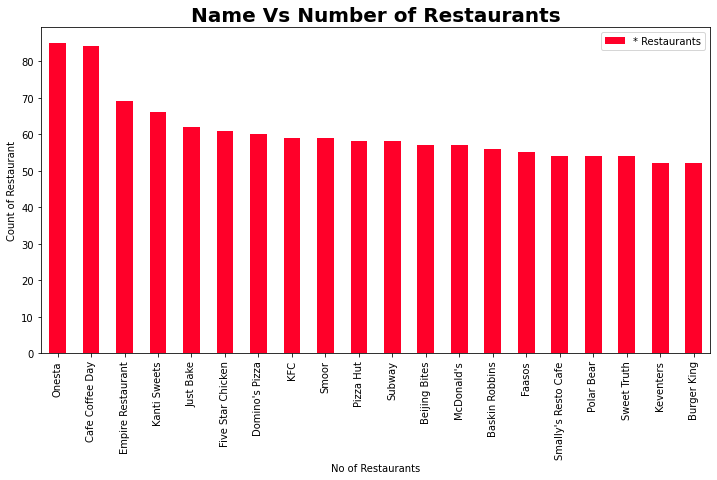

In [71]:
plt.figure(figsize=(12,6))
ax = df['name'].value_counts()[:20].plot(kind='bar', colormap= 'gist_rainbow')
ax.legend(['* Restaurants'])
plt.xlabel('No of Restaurants')
plt.ylabel('Count of Restaurant')
plt.title("Name Vs Number of Restaurants", fontsize=20, weight='bold');

Yes    24969
No     11863
Name: online_order, dtype: int64

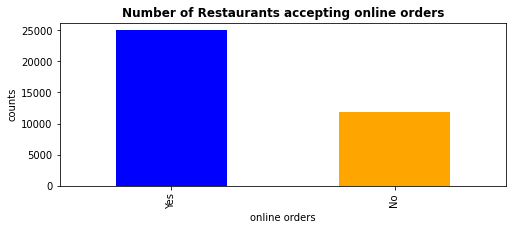

In [72]:
plt.figure(figsize=(8,3))
ax =df['online_order'].value_counts().plot(kind='bar', color={'blue','orange'})
plt.title('Number of Restaurants accepting online orders', weight='bold')
plt.xlabel('online orders')
plt.ylabel('counts')

df['online_order'].value_counts()

No     30799
Yes     6033
Name: book_table, dtype: int64

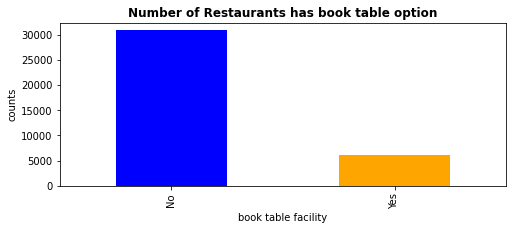

In [73]:
plt.figure(figsize=(8,3))
ax =df['book_table'].value_counts().plot(kind='bar', color={'blue','orange'})
plt.title('Number of Restaurants has book table option', weight='bold')
plt.xlabel('book table facility')
plt.ylabel('counts')

df['book_table'].value_counts()

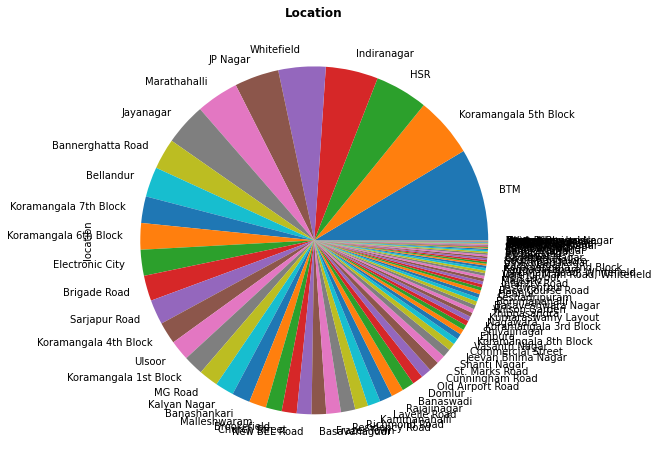

In [74]:
plt.figure(figsize=(8,8))
ax =df['location'].value_counts().plot(kind='pie')
plt.title('Location', weight='bold');

Text(0.5, 1.0, 'Location')

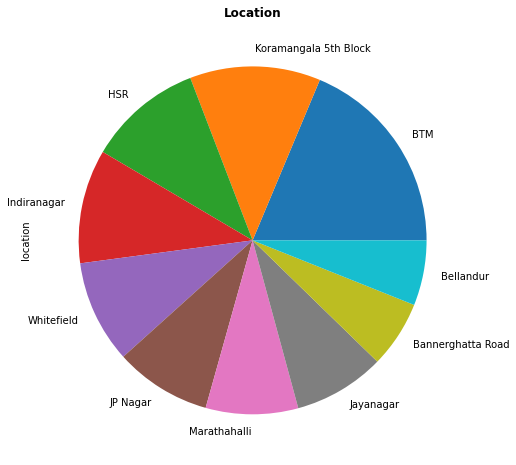

In [75]:
plt.figure(figsize=(8,8))
ax =df['location'].value_counts()[:10].plot(kind='pie')
plt.title('Location', weight='bold')

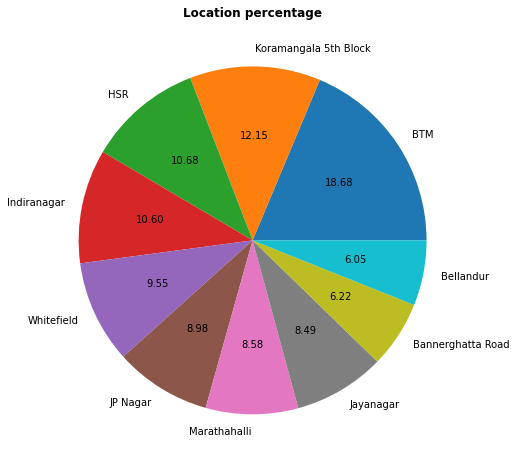

In [76]:
## https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct

plt.figure(figsize=(8,8))
values = df['location'].value_counts()[:10]
labels = df['location'].value_counts()[:10].index
plt.pie(values, labels=labels, autopct='%.2f')
plt.title('Location percentage', weight='bold')
plt.show()

Text(0, 0.5, 'counts')

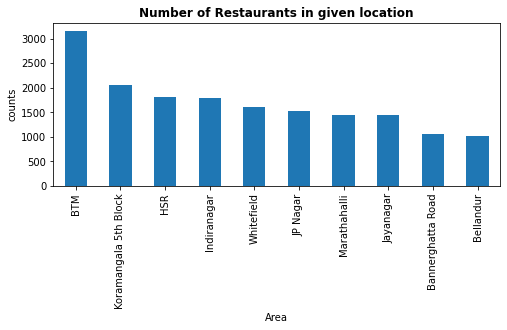

In [77]:
plt.figure(figsize=(8,3))
ax =df['location'].value_counts()[:10].plot(kind='bar')
plt.title('Number of Restaurants in given location', weight='bold')
plt.xlabel('Area')
plt.ylabel('counts')

In [78]:
df['location'].nunique() 

92

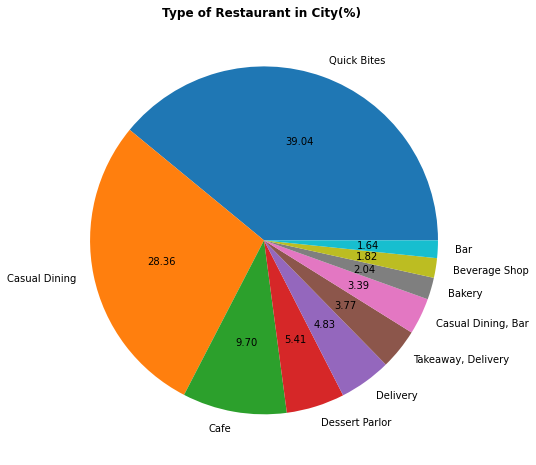

In [79]:
plt.figure(figsize=(8,8))
values = df['rest_type'].value_counts()[:10]
labels = df['rest_type'].value_counts()[:10].index
plt.pie(values, labels=labels, autopct='%.2f')
plt.title('Type of Restaurant in City(%) ', weight='bold')
plt.show()

Text(0, 0.5, 'counts')

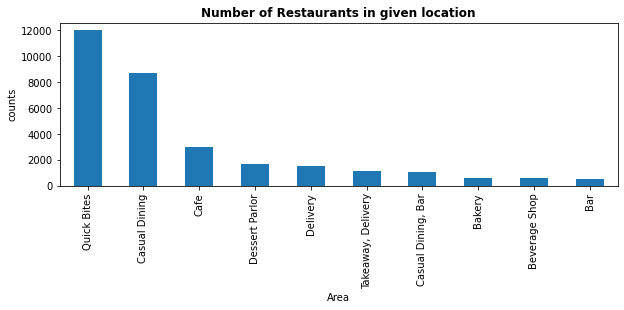

In [80]:
plt.figure(figsize=(10,3))
ax =df['rest_type'].value_counts()[:10].plot(kind='bar')
plt.title('Number of Restaurants in given location', weight='bold')
plt.xlabel('Area')
plt.ylabel('counts')

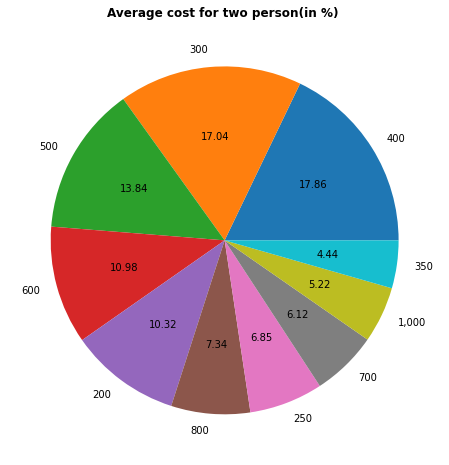

In [81]:
plt.figure(figsize=(8,8))
values = df['average_cost'].value_counts()[:10]
labels = df['average_cost'].value_counts()[:10].index
plt.pie(values, labels=labels, autopct='%.2f')
plt.title('Average cost for two person(in %) ', weight='bold')
plt.show()

In [82]:
df['dish_liked'].nunique()

7505

In [83]:
#lets delete the nulll values

data1 = df.copy()

dishes_data = data1[data1.dish_liked.notnull()]
dishes_data.dish_liked = dishes_data.dish_liked.apply(lambda x:x.lower().strip())

In [84]:
dishes_data.isnull().sum()

name                 0
online_order         0
book_table           0
rate                 0
votes                0
location             0
rest_type          121
dish_liked           0
cuisines             0
average_cost         0
reviews_list         0
menu_item            0
listed_in(type)      0
process_text         0
dtype: int64

In [85]:
dishes_data.dish_liked[:10]

0    pasta, lunch buffet, masala papad, paneer laja...
1    momos, lunch buffet, chocolate nirvana, thai g...
2    churros, cannelloni, minestrone soup, hot choc...
3                                          masala dosa
4                                  panipuri, gol gappe
5    onion rings, pasta, kadhai paneer, salads, sal...
6                                              chicken
7    farmhouse pizza, chocolate banana, virgin moji...
8    pizza, mocktails, coffee, nachos, salad, pasta...
9    waffles, pasta, coleslaw sandwich, choco waffl...
Name: dish_liked, dtype: object

In [86]:
# count each dish to see how many times each dish repeated
dish_count = []
for i in dishes_data.dish_liked: ## iterate in each rows in table
    for t in i.split(','):
        t = t.strip() # remove the white spaces to get accurate results
        dish_count.append(t)

In [87]:
dish_count[:10] 

['pasta',
 'lunch buffet',
 'masala papad',
 'paneer lajawab',
 'tomato shorba',
 'dum biryani',
 'sweet corn soup',
 'momos',
 'lunch buffet',
 'chocolate nirvana']

Text(0, 0.5, 'Count')

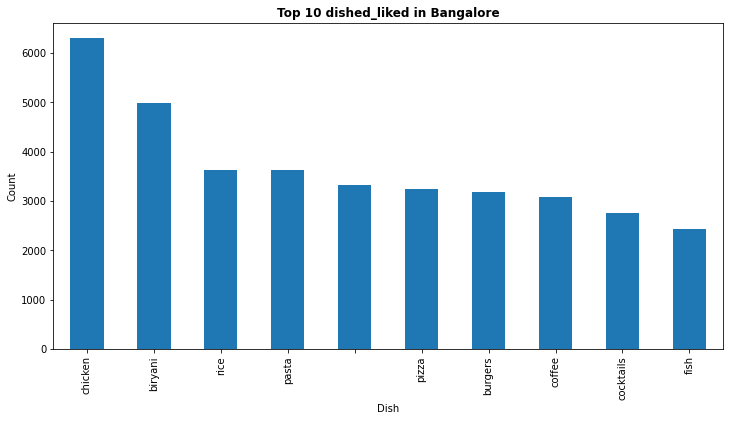

In [88]:
plt.figure(figsize=(12,6)) 
pd.Series(dish_count).value_counts()[:10].plot(kind='bar')
plt.title('Top 10 dished_liked in Bangalore',weight='bold')
plt.xlabel('Dish')
plt.ylabel('Count')

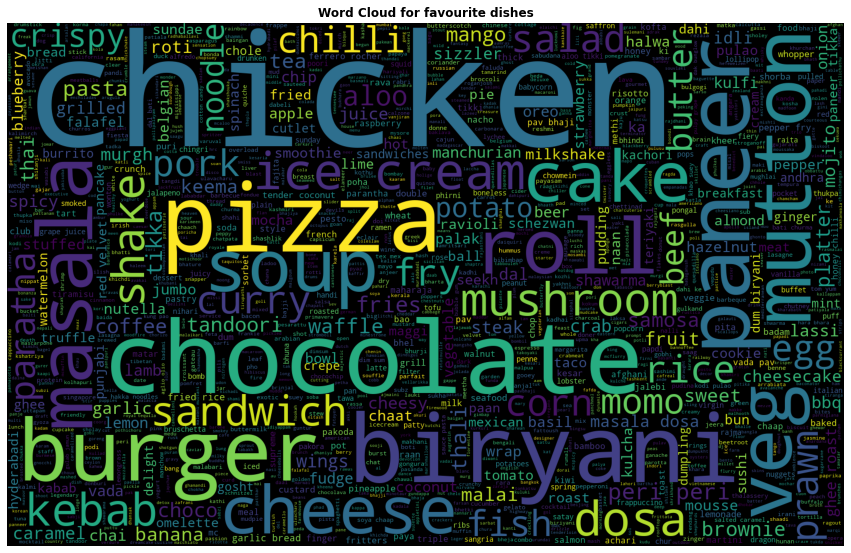

In [89]:
dish_set = set(dish_count)
dish_word_cloud = ', '.join(dish_set)

plt.figure( figsize=(15,10) )
wc = WordCloud(width=1600, height=1000,background_color="black", max_words=len(dish_word_cloud))
wc.generate(dish_word_cloud)
plt.imshow(wc, interpolation='bilinear')
plt.title('Word Cloud for favourite dishes',weight='bold')
plt.axis("off")
plt.imshow(wc)
plt.show()

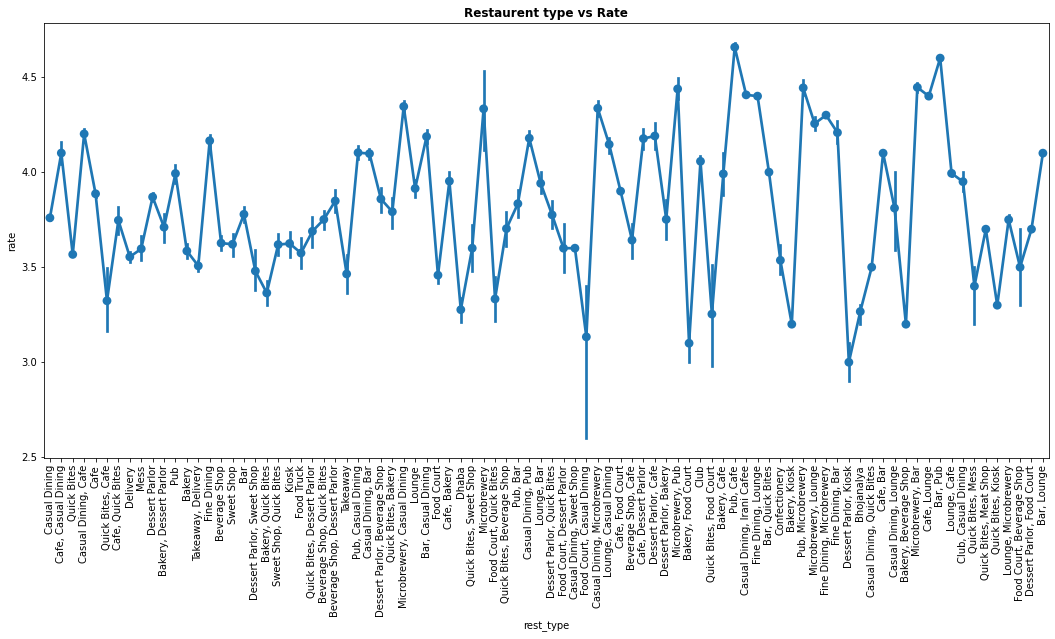

In [90]:
f,ax=plt.subplots(figsize=(18,8))
g = sns.pointplot(x=df["rest_type"], y=df["rate"], data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title('Restaurent type vs Rate', weight = 'bold')
plt.show()

In [91]:
cuisines_data = df[df.cuisines.notnull()]
cuisines_data.cuisines = cuisines_data.cuisines.apply(lambda x:x.lower().strip())

In [92]:
cuisines_count= []

for i in cuisines_data.cuisines:
    for j in i.split(','):
        j = j.strip()
        cuisines_count.append(j)

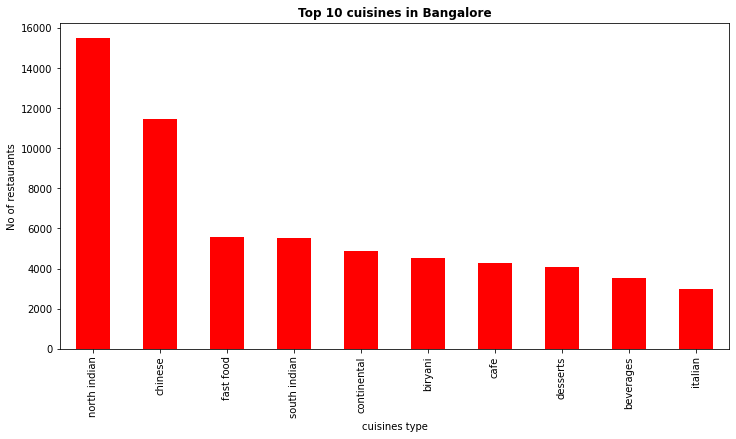

In [93]:
plt.figure(figsize=(12,6)) 
pd.Series(cuisines_count).value_counts()[:10].plot(kind='bar',color= 'r')
plt.title('Top 10 cuisines in Bangalore',weight='bold')
plt.xlabel('cuisines type')
plt.ylabel('No of restaurants');

In [94]:
cuisines_set = set(cuisines_count)
cuisines_word_cloud = ', '.join(cuisines_set)

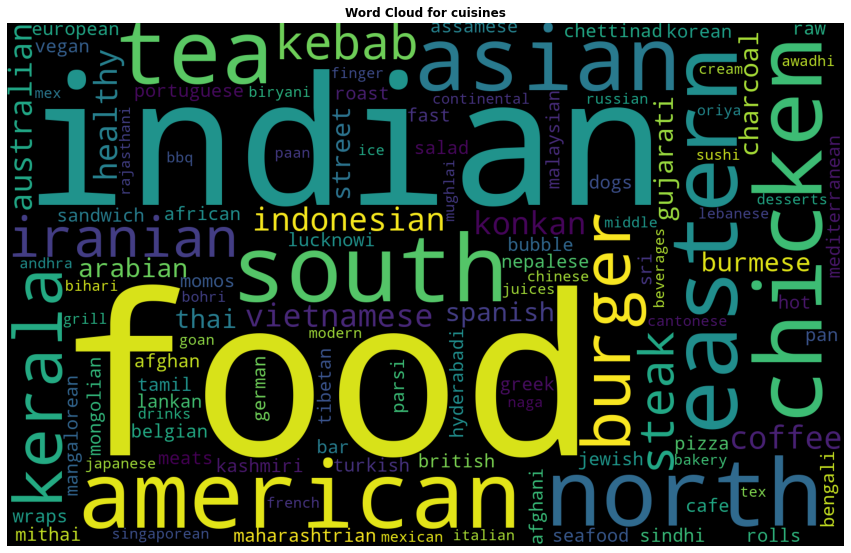

In [95]:
plt.figure( figsize=(15,10) )
wc = WordCloud(width=1600, height=1000,background_color="black", max_words=len(cuisines_word_cloud))
wc.generate(cuisines_word_cloud)
plt.title('Word Cloud for cuisines',weight='bold')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.imshow(wc)
plt.show()

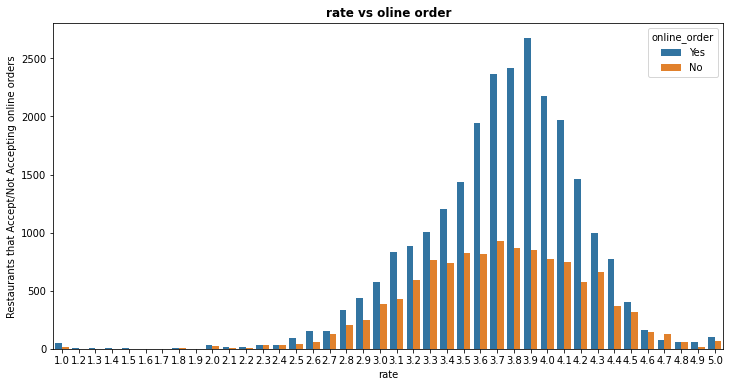

In [96]:
plt.figure(figsize = (12,6))
sns.countplot(x=df['rate'], hue = df['online_order'])
plt.ylabel("Restaurants that Accept/Not Accepting online orders")
plt.title("rate vs oline order",weight = 'bold');

In [97]:

df['online_order']= pd.get_dummies(df['online_order'], drop_first=True)
df['book_table']= pd.get_dummies(df['book_table'], drop_first=True)
df

,name,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,average_cost,reviews_list,menu_item,listed_in(type),process_text
0,Jalsa,1,1,4.1,775,Banashankari,Casual Dining,"pasta, lunch buffet, masala papad, paneer laja...","North Indian, Mughlai, Chinese",800,"[(Rated 4.0, RATED\n A beautiful place to din...",[],Buffet,a beautiful place to dine in the interiors tak...
1,Spice Elephant,1,0,4.1,787,Banashankari,Casual Dining,"momos, lunch buffet, chocolate nirvana, thai g...","Chinese, North Indian, Thai",800,"[(Rated 4.0, RATED\n Had been here for dinner...",[],Buffet,had been here for dinner with family turned o...
2,San Churro Cafe,1,0,3.8,918,Banashankari,"Cafe, Casual Dining","churros, cannelloni, minestrone soup, hot choc...","Cafe, Mexican, Italian",800,"[(Rated 3.0, RATED\n Ambience is not that goo...",[],Buffet,ambience is not that good enough and it's not ...
3,Addhuri Udupi Bhojana,0,0,3.7,88,Banashankari,Quick Bites,masala dosa,"South Indian, North Indian",300,"[(Rated 4.0, RATED\n Great food and proper Ka...",[],Buffet,great food and proper karnataka style full mea...
4,Grand Village,0,0,3.8,166,Basavanagudi,Casual Dining,"panipuri, gol gappe","North Indian, Rajasthani",600,"[(Rated 4.0, RATED\n Very good restaurant in ...",[],Buffet,very good restaurant in neighbourhood buffet ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51709,The Farm House Bar n Grill,0,0,3.7,34,Whitefield,"Casual Dining, Bar","rice, chicken, fish","North Indian, Continental",800,"[(Rated 4.0, RATED\n Ambience- Big and spacio...",[],Pubs and bars,ambience- big and spacious lawn was used to ho...
51711,Bhagini,0,0,2.5,81,Whitefield,"Casual Dining, Bar","biryani, andhra meal","Andhra, South Indian, Chinese, North Indian",800,"[(Rated 4.0, RATED\n A fine place to chill af...",[],Pubs and bars,"a fine place to chill after office hours, reas..."
51712,Best Brews - Four Points by Sheraton Bengaluru...,0,0,3.6,27,Whitefield,Bar,"decor, cocktails, chicken, mocktails",Continental,"1,500","[(Rated 5.0, RATED\n Food and service are inc...",[],Pubs and bars,food and service are incomparably excellent t...
51715,Chime - Sheraton Grand Bengaluru Whitefield Ho...,0,1,4.3,236,"ITPL Main Road, Whitefield",Bar,"cocktails, pizza, buttermilk",Finger Food,"2,500","[(Rated 4.0, RATED\n Nice and friendly place ...",[],Pubs and bars,nice and friendly place and staff is awesome ...


In [98]:
df.columns

Index(['name', 'online_order', 'book_table', 'rate', 'votes', 'location',
       'rest_type', 'dish_liked', 'cuisines', 'average_cost', 'reviews_list',
       'menu_item', 'listed_in(type)', 'process_text'],
      dtype='object')

In [99]:
# drop redudant columns
df.drop(columns=['dish_liked','reviews_list','menu_item','listed_in(type)'], inplace  =True)

In [100]:
# removed ',' between two words; then converted to categorical features
df['rest_type'] = df['rest_type'].str.replace(',' , '') 
df['rest_type'] = df['rest_type'].astype(str).apply(lambda x: ' '.join(sorted(x.split())))
df['rest_type'].value_counts().head()

Bites Quick       12006
Casual Dining      8720
Cafe               2982
Dessert Parlor     1665
Delivery           1486
Name: rest_type, dtype: int64

In [101]:
# removed ',' between two words; then converted to categorical features

df['cuisines'] = df['cuisines'].str.replace(',' , '') 
df['cuisines'] = df['cuisines'].astype(str).apply(lambda x: ' '.join(sorted(x.split())))
df['cuisines'].value_counts().head()

Chinese Indian North                 1956
Indian North                         1907
Indian South                         1034
Chinese Indian Indian North South     941
Bakery Desserts                       698
Name: cuisines, dtype: int64

In [102]:
# removed ',' between two words; then converted to string to int

df['average_cost'] = df['average_cost'].str.replace(',' , '') 
df['average_cost'] = df['average_cost'].apply(int)

In [103]:
df.head(3)

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,average_cost,process_text
0,Jalsa,1,1,4.1,775,Banashankari,Casual Dining,Chinese Indian Mughlai North,800,a beautiful place to dine in the interiors tak...
1,Spice Elephant,1,0,4.1,787,Banashankari,Casual Dining,Chinese Indian North Thai,800,had been here for dinner with family turned o...
2,San Churro Cafe,1,0,3.8,918,Banashankari,Cafe Casual Dining,Cafe Italian Mexican,800,ambience is not that good enough and it's not ...


In [104]:
# build x & y dataset
x = df.drop(['rate','name','process_text'],axis = 1)
y = df['rate']

In [105]:
x.head()

,online_order,book_table,votes,location,rest_type,cuisines,average_cost
0,1,1,775,Banashankari,Casual Dining,Chinese Indian Mughlai North,800
1,1,0,787,Banashankari,Casual Dining,Chinese Indian North Thai,800
2,1,0,918,Banashankari,Cafe Casual Dining,Cafe Italian Mexican,800
3,0,0,88,Banashankari,Bites Quick,Indian Indian North South,300
4,0,0,166,Basavanagudi,Casual Dining,Indian North Rajasthani,600


In [106]:
y.head()

0    4.1
1    4.1
2    3.8
3    3.7
4    3.8
Name: rate, dtype: float64

In [107]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state = 33)

In [108]:
# save to local disk
print(dump(X_train, filename='pkl_files_X_train'))
print(dump(X_test, filename='pkl_files_X_test'))
print(dump(y_train, filename='pkl_files_y_train'))
print(dump(y_test, filename='pkl_files_y_test'))

['pkl_files_X_train']
['pkl_files_X_test']
['pkl_files_y_train']
['pkl_files_y_test']


In [109]:
X_train = load('pkl_files_X_train')
X_test = load('pkl_files_X_test')
y_train = load('pkl_files_y_train')
y_test = load('pkl_files_y_test')

In [110]:
# X_train.head(2)

In [111]:
enc = OneHotEncoder( handle_unknown='ignore')

In [112]:
## ALWAYS AVOID DATA LEAKAGE

# this method is for training data set
def one_hot_fit_transform(df,name):
    output_data = df[name].values.reshape(-1, 1)
    return enc.fit_transform(output_data).toarray()

# this method is for test data set
def one_hot_transform(df,name):
    output_data1 = df[name].values.reshape(-1, 1)
    return enc.transform(output_data1).toarray()

In [113]:
# one hot encoding apply to 'rest_type' features on train/test dataset
tr_dummy_rest_type = one_hot_fit_transform(X_train,'rest_type' )
te_dummy_rest_type= one_hot_transform(X_test,'rest_type' )

# one hot encoding apply to 'location' features on train/test dataset
tr_dummy_city = one_hot_fit_transform(X_train,'location' )
te_dummy_city= one_hot_transform(X_test,'location')

# one hot encoding apply to 'cuisines' features on train/test dataset
tr_dummy_cuisines = one_hot_fit_transform(X_train,'cuisines' )
te_dummy_cuisines=one_hot_transform(X_test,'cuisines')

In [114]:
tr_dummy_rest_type.shape, te_dummy_rest_type.shape

((25782, 67), (11050, 67))

In [115]:
tr_dummy_city.shape, te_dummy_city.shape

((25782, 92), (11050, 92))

In [116]:
tr_dummy_cuisines.shape, te_dummy_cuisines.shape

((25782, 1674), (11050, 1674))

In [117]:
## combine all 'one-hot' encoded features as Tr.
tr =pd.DataFrame(pd.np.column_stack([ tr_dummy_rest_type,tr_dummy_city, tr_dummy_cuisines]))

## CONCAT both dataframe ### ie Tr and X_train(original dataframe)
## https://stackoverflow.com/questions/45963799/pandas-concat-resulting-in-nan-rows

l1=X_train.values.tolist()
l2=tr.values.tolist()

for i in range(len(l1)):
    l1[i].extend(l2[i])

X_train=pd.DataFrame(l1,columns=X_train.columns.tolist()+tr.columns.tolist())
X_train.shape

(25782, 1840)

In [118]:
## combine all 'one-hot' encoded features as Te.
te =pd.DataFrame(pd.np.column_stack([ te_dummy_rest_type,te_dummy_city,te_dummy_cuisines]))

## CONCAT both dataframe ### ie Te and X_test(original dataframe)
## https://stackoverflow.com/questions/45963799/pandas-concat-resulting-in-nan-rows

l3=X_test.values.tolist()
l4=te.values.tolist()
for i in range(len(l3)):
    l3[i].extend(l4[i])

X_test=pd.DataFrame(l3,columns=X_test.columns.tolist()+te.columns.tolist())
X_test.shape

(11050, 1840)

In [119]:
# after onehot encoding DONE. 'location','rest_type','cuisines' are redundant features. REMOVE them.

X_train =X_train.drop(['location','rest_type','cuisines'],axis = 1)
X_test =X_test.drop(['location','rest_type','cuisines'],axis = 1)

In [120]:
X_train.head(3)

,online_order,book_table,votes,average_cost,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,1793,1794,1795,1796,1797,1798,1799,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832
0,0,1,1390,1400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,1218,1200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,34,300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
print(x.shape)
print(y.shape)

(36832, 7)
(36832,)


In [122]:
# checking final train set shape
X_train.shape, y_train.shape

((25782, 1837), (25782,))

In [123]:
# # checking final test set shape
X_test.shape, y_test.shape

((11050, 1837), (11050,))

In [124]:
print(dump(X_train, 'max_features_pkl_X_train'))
print(dump(X_test, 'max_features_pkl_X_test'))
print(dump(y_train, 'max_features_pkl_y_train'))
print(dump(y_test, 'max_features_pkl_y_test'))

['max_features_pkl_X_train']
['max_features_pkl_X_test']
['max_features_pkl_y_train']
['max_features_pkl_y_test']


In [125]:
X_train= load('max_features_pkl_X_train') 
X_test= load('max_features_pkl_X_test')
y_train= load('max_features_pkl_y_train')
y_test= load('max_features_pkl_y_test')

In [126]:
from sklearn.metrics import  make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn import metrics


def mse(y, y_pred):
    return np.mean((y_pred - y)**2) 

mse_scorer = make_scorer(mse, greater_is_better=False)

In [127]:
import random

rand_pred= np.zeros(y_test.shape[0])
for i in range(y_test.shape[0]):
    rand_probs = round(random.uniform(1.0, 5.0),2)
    rand_pred[i] = rand_probs

mse(y_test, rand_pred)

2.1210286787330244

In [128]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)

mse(y_test, y_pred_lr)

0.12780356343783797

In [129]:
from sklearn import linear_model

sgdReg = linear_model.SGDRegressor()
sgdReg.fit(X_train,y_train)
y_pred_sgdr = sgdReg.predict(X_test)

mse(y_test, y_pred_sgdr)

1.587328397183066e+29

In [131]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_jobs=-1, eval_metric='rmse', random_state=1,verbose_eval=10)
xgb.fit(X_train,y_train)
y_pred_xgb = xgb.predict(X_test)

mse(y_test, y_pred_xgb)

0.17080090497736905

In [132]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
y_pred_rfr = rfr.predict(X_test)

mse(y_test, y_pred_rfr)

0.034644019296742046

In [133]:
# tuned_parameters = {'n_estimators': [250,500,1000,1200]}

# grd_regressor = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=10, 
#                    n_jobs=-1, verbose=1, scoring=mse_scorer)
# grd_regressor.fit(X_train, y_train)

In [134]:
rfr = RandomForestRegressor(max_depth=None,n_estimators=200,min_samples_split= 2)
rfr.fit(X_train,y_train)
y_pred_rfr = rfr.predict(X_test)

mse(y_test, y_pred_rfr)

0.034436271914684694

In [136]:
Rand_pred = pd.DataFrame({ "actual": y_test, "pred": y_pred_rfr })
Rand_pred

,actual,pred
17780,3.6,3.571500
35810,3.8,3.776000
25324,4.1,4.123500
13990,3.5,3.469600
8655,3.1,3.070067
...,...,...
46443,3.9,3.898500
24395,4.0,3.971000
21119,3.7,3.662000
43452,4.0,3.997500


In [140]:
# Use pickle to save our model so that we can use it later

import pickle 
# Saving model to disk
pickle.dump(rfr, open('model.pkl','wb'))
model=pickle.load(open('model.pkl','rb'))